# 0. 프로젝트: SentencePiece를 사용한 감정 분석

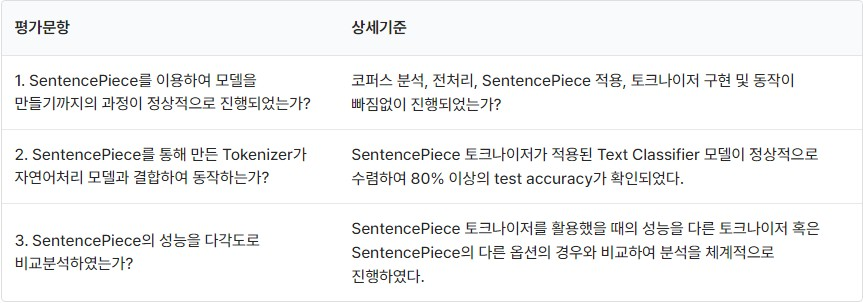

SentencePiece를 사용해 감정 분석을 해보자.  

SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것이다. 아래 링크의 페이지에서 상세한 내용을 파악할 수 있다.  
https://github.com/google/sentencepiece  
위 페이지의 서두에서도 언급하고 있듯, SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있는데, 최근 pretrained model들이 거의 대부분 SentencePiece를 tokenizer로 채용하면서 사실상 표준의 역할을 하고 있다.

In [1]:
import os, re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# !pip install sentencepiece
import sentencepiece as spm
# !pip install konlpy
import konlpy

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

In [2]:
tf.random.set_seed(9)
np.random.seed(9)

In [3]:
env = os.getenv('HOME') + '/aiffel/sp_tokenizer/data'

# 1. 데이터 불러오기

https://github.com/e9t/nsmc/  
Naver sentiment movie corpus 데이터를 사용한다.

Each file is consisted of three columns: id, document, label  
- id: The review id, provieded by Naver  
- document: The actual review  
- label: The sentiment class of the review. (0: negative, 1: positive)  
- Columns are delimited with tabs (i.e., .tsv format; but the file extension is .txt for easy access for novices)  

200K reviews in total  
- ratings.txt: All 200K reviews  
- ratings_test.txt: 50K reviews held out for testing  
- ratings_train.txt: 150K reviews for training  

In [4]:
ratings_train = pd.read_table(env + '/ratings_train.txt')
ratings_test = pd.read_table(env + '/ratings_test.txt')

In [5]:
ratings_train.tail()

,id,document,label
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1
149999,9619869,한국 영화 최초로 수간하는 내용이 담긴 영화,0


In [6]:
ratings_test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


원활한 학습을 위해 중복된 데이터를 제거하고 결측 데이터도 제거한다.

In [7]:
ratings_train = ratings_train.drop_duplicates(subset=['document']).dropna(how='any').reset_index(drop=True)
ratings_test = ratings_test.drop_duplicates(subset=['document']).dropna(how='any').reset_index(drop=True)


# 2. 코퍼스 분석하기

편의를 위해 train 데이터와 test 데이터를 합칠 건데  
그 전에 train 데이터과 test 데이터를 구분짓는 샘플의 특징(여기서는 id 변수)을 추출해서 기억해놓는다.

In [8]:
train_end_id = ratings_train.iloc[-1]['id']
print(train_end_id)

9619869


In [9]:
ratings = pd.concat([ratings_train, ratings_test]).reset_index(drop=True)
ratings

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
195334,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
195335,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
195336,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
195337,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


NLP하기 위해서는 모든 문장들이 같은 길이를 가지고 있어야 하는데  
적당한 길이로 자르지 않으면 짧은 문장들의 패딩이 많아져서 불필요한 계산 비용이 발생한다.

따라서 적당한 길이를 알아보기 위해 문장의 최단 길이, 최장 길이, 평균 길이 및 길이의 분포를 살펴보자.

In [10]:
def cal_sentence_length(raw):
    sen_lens = [len(sen) for sen in raw]

    print("문장의 최단 길이:", min(sen_lens))
    print("문장의 최장 길이:", max(sen_lens))
    print("문장의 평균 길이:", sum(sen_lens) // len(raw))

    sentence_length = np.zeros((max(sen_lens)), dtype=np.int)

    for i in range(max(sen_lens)):
        sentence_length[i] += sen_lens.count(i)

    plt.bar(range(max(sen_lens)), sentence_length, width=1.0)
    plt.title("Sentence Length Distribution")
    plt.show()

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


/tmp/ipykernel_5581/3097477280.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max(sen_lens)), dtype=np.int)


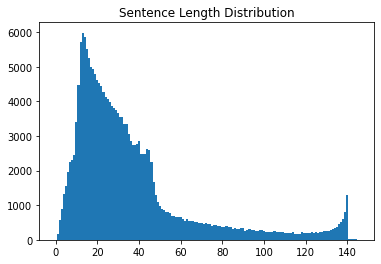

In [11]:
cal_sentence_length(ratings['document'])

우선 평균보다는 길고, 그래프가 급격히 얇아지는 구간에서 자를 필요가 있어보인다.  

우선 문장 길이가 1인 데이터는 어떤 것들이 있는지 알아보자.

In [12]:
def check_sentence_with_length(raw, length):
    count = 0
    sen_list = []
    
    for sen in raw:
        if len(sen) == length:
            sen_list.append(sen)
            count += 1
            if count > 100:
                return sen_list

In [13]:
print(check_sentence_with_length(ratings['document'], 3))

['좋구나', '10점', '처ㅝ주', '솔직히', '4대강', '재밌다', '재밌군', '좋았다', '재미무', '보지마', '볼만함', 'b b', 'dsa', '웃스!', '♥♥♥', '재밋네', '최고다', '재밌음', '쓰래기', '갑이다', '료코짱', '2빠닼', '만세-', 'OOO', 'ㅋㅋㅋ', '아하!', '재및음', '좋아여', '재미쪙', '대박!', '에혀~', '3.6', '가보자', 'bad', '신선함', '와우!', '즐ㄹㅋ', '좋아요', '아ㅅㅂ', '쨩이야', '굿~!', 'ㅉㅉㅉ', '재밋다', '지못미', '나이스', '오짱!', '전형적', '원주율', '좋은테', '2.6', '굿!!', '1등?', '보세요', '잼없다', '다섯개', '접어라', '쓰중쓰', '좋다.', '음..', '좋군.', '싸우자', '멋져.', '...', '직인다', '짱짱짱', '별로임', '진리임', '감동적', '최고!', '재밌어', '걍 굿', '아시바', '최고~', '팬이다', '별로다', '좋다,', '잼있다', '최고.', '감동!', '잠온다', '의리!', '별로~', '즐..', '썩었내', '짱멋짐', 'ㄴㄹㄴ', '성룡짱', '꿀잼♥', '쵝오!', '괜찮네', '막장.', '억지.', '김서울', '철규찡', '무셔움', '지겨워', '꼭보셈', '쓰레기', '그다지', '훌륭함', '최고임']


In [14]:
print(check_sentence_with_length(ratings['document'], 4))

['재밋는뎅', '킬링타임', '별로다.', '볼만해;', '연기 굿', '좋은영화', '굿 좋아', '재밌는데', '와...', '펑점조절', '싸우자!', '최고!!', '패륜영화', '어휴..', '재밌다.', '괜히봤다', '재미없음', '지루하다', '재미없다', '장난치냐', 'OOO기', '몰떡몰떡', 'good', '이건뭥미', '잼슴ㅇㅎ', '죽을래?', '짠하네요', '기대된디', '보고싶다', '나도별로', '추억돋네', '재밌어요', '야동!!', '왜봣지?', '볼만했음', '별로;;', '평점조절', '심하네.', '별로네요', '돈아깝다', '별10개', '최고다.', '어이없다', '별루 .', '굿입니당', '옥빈님짱', '언제꺼임', '-_-^', '뭐냐이게', '개쩔었다', '그지같다', '안무섭다', '푹 잤음', '재밌네요', '괜찬았음', '안과 겉', '참쩔어요', '재 밌다', '별론데?', '괜찬군요', '최고지~', '걍 평작', '명작이다', '재밋구만', '공블리짱', '잼나ㅎㅎ', '""""', '으하하하', '그만하자', '별로..', '...굿', '이건멍미', '재밌다!', '보영누나', '달달..', '허술하다', '넘잼있음', '재미있다', '좋았어요', '재밋어여', '씹쓰레기', '선동영화', '별로 ㅋ', '레전드.', '애절하다', '이연걸~', '재미없엉', '재미있음', '넘 잼따', '적절하다', '쩝...', '안습..', '지루력!', '최고였다', '훈훈하다', '뭘봐!!', '재밌던데', '쒸레기~', '최고이지', '의리다.', '쓰렉이얌']


길이가 4인 문장부터는 거의 완전히 호불호가 드러난 것으로 보인다.  

최대 길이를 50 이상으로 잡아서 대부분의 데이터를 살리면서도  
그 중에 가장 작은 2의 거듭제곱인 64를 선택해서 패딩을 최소한으로 하겠다.

In [15]:
# point
min_len = 2 ** 2
max_len = 2 ** 6

In [16]:
# 길이 조건에 맞는 문장만 선택합니다.
ratings = ratings[ratings['document'].apply(lambda x: min_len <= len(x) <= max_len)]
print("Data Size:", len(ratings))


Data Size: 168532


In [17]:
print(f'잘린 길이 비율: {(146 - 64) / 146 * 100:.2f}%')
print(f'삭제한 데이터 비율: {(195339-168532) / 195339 * 100:.2f}%')

잘린 길이 비율: 56.16%
삭제한 데이터 비율: 13.72%


길이를 56%나 줄였지만 데이터는 13%밖에 삭제되지 않았다.

문장의 최단 길이: 4
문장의 최장 길이: 64
문장의 평균 길이: 26


/tmp/ipykernel_5581/3097477280.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max(sen_lens)), dtype=np.int)


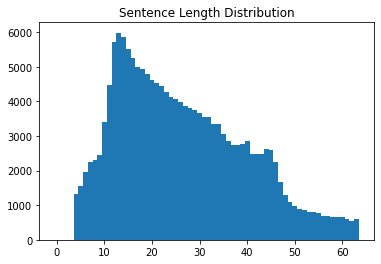

In [18]:
cal_sentence_length(ratings['document'])

In [19]:
ratings

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
195334,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
195335,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
195336,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
195337,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


# 3. 전처리하기

기본적인 문장 전처리를 해보자.

In [20]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 로마자를 전부 소문자로 바꿉니다.
    sentence = sentence.lower()
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # (a-z, A-Z, ㄱ-ㅣ, 가-힣, 0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅣ가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [21]:
preprocess_sentence('  ㄱ     A         B    ㅗ    ')

'ㄱ a b ㅗ'

In [22]:
ratings['document'] = ratings['document'].apply(preprocess_sentence)
ratings.head()

/tmp/ipykernel_5581/2981830919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['document'] = ratings['document'].apply(preprocess_sentence)


,id,document,label
0,9976970,아 더빙 . . 진짜 짜증나네요 목소리,0
1,3819312,흠 . . . 포스터보고 초딩영화줄 . . . . 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 . . 솔직히 재미는 없다 . . 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 ! 스파이더맨에서 늙어보이기만 했던 커스...,1


In [23]:
ratings.isna().sum()

id          0
document    0
label       0
dtype: int64

전처리로 인해 결측치로 변해버린 데이터는 없었다.

# 4. SentencePiece의 unigram 모델 사용하기

SentencePiece는 공백 기반도, 형태소 기반도 아닌 서브워드 기반 토크나이저이다.  
서브워드는 예시로 보는 것이 가장 이해하기 쉽다.  
i am a boy and you are a girl  
라는 문장을 각 알파벳별로 나누고 가능도가 높은 문자 쌍으로 합친  
[_i, _am, _a, _b, o, y, _a, n, d, _you, _are, _a, _gir, l]  
토큰들로 나눴을 때 각 토큰이 서브워드인 것이다.

우선 Unigram 모델을 사용할 건데 BPE와의 차이점은 아래와 같다.

BPE: 사전에 정의한 vocabulary size에 도달하기 전까지 매 iteration마다 단지 등장 빈도수만을 확인하여 가장 많이 등장한 pair를 subword set에 추가한다.
Unigram: 등장 빈도수는 전혀 사용하지 않고오직 확률모델을 사용한다. 대신 확률 모델을 사용하여 language Model을 훈련시킨다. 가장 적게 전반적인 likelihood를 개선한 token들을 삭제하고 final token limit을 만날 때까지 계속한다.

우선 corpus를 텍스트 파일로 저장하고  
그 파일에 센텐스피스 토크나이저를 수행하면  
모델과 단어사전을 파일로 저장시켜준다.  
신기한 점은 프로세서 인스턴스를 생성하고 퍼래머더를 지정하는 방식이 아닌  
라이브러리로 바로 학습을 시키고 파일로 저장시킨 후 파일을 불러오는 방식인 것으로 보인다.  
따라서 다른 퍼래머더를 적용시키려면 또 모델 파일을 생성해야한다.

In [24]:
temp_file = env + '/ratings.txt.temp'

with open(temp_file, 'w') as f:
    for row in ratings['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')
        
model_type = 'unigram'
spm.SentencePieceTrainer.Train('--input={} --model_prefix=korean_spm --model_type={}'.format(temp_file, model_type))

#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/ratings.txt.temp --model_prefix=korean_spm --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/ratings.txt.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  p

-rw-r--r-- 1 root root 377797 Nov 28 04:51 korean_spm.model
-rw-r--r-- 1 root root 147285 Nov 28 04:51 korean_spm.vocab


학습된 파일을 로드한 후 학습이 잘 되었는지 확인하기 위한 예시를 보자.

In [25]:
spp = spm.SentencePieceProcessor()
spp.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = spp.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(spp.SampleEncodeAsPieces('아버지가방에들어가신다.', 1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(spp.DecodeIds(tokensIDs))

[1458, 11, 460, 15, 1365, 11, 167, 16, 7999]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


EncodeAsIds 메소드는 정수 토큰을 불러온다.  
SampleEncodeAsPieces 메소드는 텍스트 토큰을 불러온다.  
DecodeIds 메소드는 텍스트 토큰을 합쳐서 보여준다.(사실상 원본)

# 5. Tokenizer 함수 작성하기

word_to_index, index_to_word 사전을 만들고  
학습을 위해 패딩을 붙여보자.  
단, korean_spm.vocab 파일에는 pad 토큰이 없어서  
0번 인덱스가 \<unk>이므로 한 칸씩 뒤로 당긴 후  
0번 인덱스가 \<pad>가 되게끔 만들어준다.

In [26]:
def sp_tokenize(spp, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(list(map(lambda x: x+1, spp.EncodeAsIds(sen))))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {'<pad>': 0}
    index_word = {0: '<pad>'}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx+1})
        index_word.update({idx+1:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [27]:
#sp_tokenize(spp, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
print(sp_tokenize(spp, my_corpus)[0])

[[ 475 2990   15 1242 2661 8000    0    0    0    0    0    0]
 [1238 1987  143  533   12    5   18 7921  706 8000 8000 8000]]


모델에 적용시킬 X 데이터를 생성.

In [28]:
ratings_X, word_index, index_word = sp_tokenize(spp, ratings['document'])

In [29]:
print(ratings_X.shape)
ratings_X

(168532, 60)


array([[  42,  911,    4, ...,    0,    0,    0],
       [1212,    4,    4, ...,    0,    0,    0],
       [  21,  485, 7810, ...,    0,    0,    0],
       ...,
       [1937,   13,  577, ...,    0,    0,    0],
       [ 553, 1305,   14, ...,    0,    0,    0],
       [1779,   14,  193, ...,    0,    0,    0]], dtype=int32)

In [30]:
vocab_size = len(word_index) # 단어의 수
vocab_size

8001

단어사전 크기는 8000(센텐스피스 기본값) + 1(pad) = 8001이다.

센텐스피스가 적용된 실제 데이터를 몇개 살펴보자.

In [31]:
for i, tokens in enumerate(ratings_X[: 5]):
    print([index_word[token] for token in tokens if index_word[token] not in ['<pad>', '<unk>']])
    print(ratings['label'].iloc[i])

['▁아', '▁더빙', '▁.', '▁.', '▁진짜', '▁짜증나', '네요', '▁목소리']
0
['▁흠', '▁.', '▁.', '▁.', '▁포스터', '보고', '▁초딩', '영화', '줄', '▁.', '▁.', '▁.', '▁.', '▁오버', '연기', '조차', '▁가볍', '지', '▁않', '구나']
1
['▁너무', '재', '밓', '었다', '그래', '서', '보는', '것을', '추천', '한다']
0
['▁교', '도', '소', '▁이야기', '구먼', '▁.', '▁.', '▁솔직히', '▁재미는', '▁없다', '▁.', '▁.', '▁평점', '▁조정']
0
['▁사이', '몬', '페', '그', '의', '▁', '익', '살', '스런', '▁연기가', '▁돋보였', '던', '▁영화', '▁!', '▁스파이더맨', '에서', '▁늙어', '보이', '기만', '▁했던', '▁커', '스틴', '▁', '던', '스트', '가', '▁너무나도', '▁이뻐', '보', '였다']
1


다시 훈련 데이터와 평가 데이터를 나누기 위해 train_end_id를 가진 데이터의 인덱스를 추출한다.

In [32]:
train_end_idx = np.array(range(len(ratings)))[ratings['id'] == train_end_id][0]

train_end_idx

126229

In [33]:
ratings.iloc[train_end_idx]

id                           9619869
document    한국 영화 최초로 수간하는 내용이 담긴 영화
label                              0
Name: 146181, dtype: object

아까 그 훈련 데이터의 마지막 데이터가 맞다.

In [34]:
train_X = ratings_X[: train_end_idx+1]
test_X = ratings_X[train_end_idx+1: ]

train_y = np.array(ratings['label'][: train_end_idx+1], dtype='float32')
test_y = np.array(ratings['label'][train_end_idx+1: ], dtype='float32')

In [35]:
print(train_X.shape)
print(test_X.shape)

print(train_y.shape)
print(test_y.shape)

(126230, 60)
(42302, 60)
(126230,)
(42302,)


# 6. validation set 구성 및 모델 구성

훈련 상태을 확인하기 위한 검증 데이터를 훈련 데이터에서 분할한다.

In [36]:
def tsize(train_X):
    length = len(train_X)
    return round(0.14 * (1 + length / 10 ** 4) ** (10 ** 4 / length) - 0.13, 2)

tsize(train_X)


0.04

훈련 데이터가 많아서 검증 데이터를 4%만 분할해도 괜찮을 것 같다.

In [37]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=tsize(train_X))


In [38]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(121180, 60)
(5050, 60)
(121180,)
(5050,)


간단한 LSTM 모델 생성.

In [39]:
# point
class model_maker(tf.keras.Model):
    def __init__(self, vocab_size, word_vector_dim, units):
        super().__init__()
        self.embedding1 = layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, ))
        self.lstm1 = layers.Bidirectional(layers.LSTM(units))
        self.drop1 = layers.Dropout(0.5)
        self.dense2 = layers.Dense(1, activation='sigmoid')
        
    def call(self, x):
        x = self.embedding1(x)
        x = self.lstm1(x)
        x = self.drop1(x)
        x = self.dense2(x)
        
        return x


In [40]:
# point
word_vector_dim = 2 ** 6
units = int(word_vector_dim / 2)

model = model_maker(vocab_size, word_vector_dim, units)

# 7. 모델 훈련하기

In [41]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 2 ** 4

early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=2**10, # point
                    validation_data=(X_val, y_val),
                    verbose=1,
                   callbacks=[early_stop])

Epoch 1/16
119/119 [==============================] - 7s 20ms/step - loss: 0.5403 - accuracy: 0.7232 - val_loss: 0.3825 - val_accuracy: 0.8360
Epoch 2/16
119/119 [==============================] - 2s 14ms/step - loss: 0.3519 - accuracy: 0.8546 - val_loss: 0.3457 - val_accuracy: 0.8501
Epoch 3/16
119/119 [==============================] - 2s 14ms/step - loss: 0.3184 - accuracy: 0.8675 - val_loss: 0.3429 - val_accuracy: 0.8533
Epoch 4/16
119/119 [==============================] - 2s 14ms/step - loss: 0.3002 - accuracy: 0.8741 - val_loss: 0.3392 - val_accuracy: 0.8531
Epoch 5/16
119/119 [==============================] - 2s 14ms/step - loss: 0.2855 - accuracy: 0.8805 - val_loss: 0.3468 - val_accuracy: 0.8552
Epoch 6/16
119/119 [==============================] - 2s 14ms/step - loss: 0.2707 - accuracy: 0.8864 - val_loss: 0.3586 - val_accuracy: 0.8549
Epoch 7/16
119/119 [==============================] - 2s 14ms/step - loss: 0.2567 - accuracy: 0.8927 - val_loss: 0.3751 - val_accuracy: 0.8483

In [42]:
def history_plot(history):
    y_acc = history.history['accuracy']
    y_vacc = history.history['val_accuracy']
    
    y_loss = history.history['loss']
    y_vloss = history.history['val_loss']

    epochs_range = range(len(y_acc))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, y_acc, marker='.', label="Train-set accuracy")
    plt.plot(epochs_range, y_vacc, marker='.', label="Validation-set accuracy")
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(0.5, 1) 
    plt.title('Accurcy graph with batch normalization') 
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, y_loss, marker='.', label="Train-set Loss")
    plt.plot(epochs_range, y_vloss, marker='.', label="Validation-set Loss")
    plt.legend(loc='upper right')
    plt.grid()
    plt.title('Loss graph with batch normalization') 
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.show()

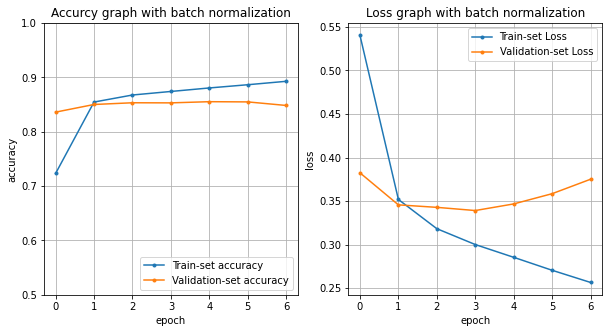

In [43]:
history_plot(history)

In [44]:
result = model.evaluate(test_X, test_y, verbose=1)

1322/1322 [==============================] - 5s 4ms/step - loss: 0.3797 - accuracy: 0.8454


# 8. SentencePiece의 BPE 모델 사용하기

이번에는 bpe 모델을 사용해서 unigram과의 성능 차이를 확인해 보겠다.

In [45]:
model_type = 'bpe'
spm.SentencePieceTrainer.Train('--input={} --model_prefix=korean_spm --model_type={}'.format(temp_file, model_type))

#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/ratings.txt.temp --model_prefix=korean_spm --model_type=bpe
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/ratings.txt.temp
  input_format: 
  model_prefix: korean_spm
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -

-rw-r--r-- 1 root root 373120 Nov 28 04:52 korean_spm.model
-rw-r--r-- 1 root root 118346 Nov 28 04:52 korean_spm.vocab


In [46]:
spp = spm.SentencePieceProcessor()
spp.Load('korean_spm.model')

ratings_X, word_index, index_word = sp_tokenize(spp, ratings['document'])

train_X = ratings_X[: train_end_idx+1]
test_X = ratings_X[train_end_idx+1: ]

train_y = np.array(ratings['label'][: train_end_idx+1], dtype='float32')
test_y = np.array(ratings['label'][train_end_idx+1: ], dtype='float32')

X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=tsize(train_X))


# point
word_vector_dim = 2 ** 6
units = int(word_vector_dim / 2)

model = model_maker(vocab_size, word_vector_dim, units)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 2 ** 4

early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=2**10, # point
                    validation_data=(X_val, y_val),
                    verbose=1,
                   callbacks=[early_stop])

Epoch 1/16
119/119 [==============================] - 5s 20ms/step - loss: 0.5435 - accuracy: 0.7315 - val_loss: 0.3783 - val_accuracy: 0.8455
Epoch 2/16
119/119 [==============================] - 2s 14ms/step - loss: 0.3569 - accuracy: 0.8531 - val_loss: 0.3466 - val_accuracy: 0.8491
Epoch 3/16
119/119 [==============================] - 2s 14ms/step - loss: 0.3239 - accuracy: 0.8656 - val_loss: 0.3403 - val_accuracy: 0.8505
Epoch 4/16
119/119 [==============================] - 2s 14ms/step - loss: 0.3091 - accuracy: 0.8706 - val_loss: 0.3367 - val_accuracy: 0.8554
Epoch 5/16
119/119 [==============================] - 2s 14ms/step - loss: 0.2944 - accuracy: 0.8772 - val_loss: 0.3445 - val_accuracy: 0.8537
Epoch 6/16
119/119 [==============================] - 2s 14ms/step - loss: 0.2817 - accuracy: 0.8814 - val_loss: 0.3399 - val_accuracy: 0.8564
Epoch 7/16
119/119 [==============================] - 2s 14ms/step - loss: 0.2676 - accuracy: 0.8870 - val_loss: 0.3519 - val_accuracy: 0.8552

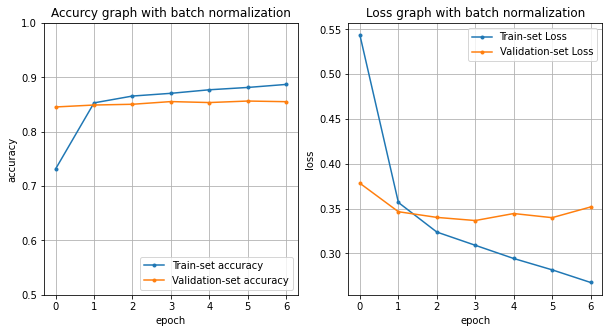

In [47]:
history_plot(history)

In [48]:
result = model.evaluate(test_X,  test_y, verbose=1)

1322/1322 [==============================] - 5s 4ms/step - loss: 0.3628 - accuracy: 0.8485


In [50]:
print('unigram의 accuracy: 0.8454')
print('bpe의 accuracy: 0.8485')

unigram의 accuracy: 0.8454
bpe의 accuracy: 0.8485


두 토크나이저의 성능 차이가 별로 나지 않았다.  
그래도 그나마 성능이 나은 건 bpe다.  
둘 다 딥러닝에 최적화된 모델이다 보니 쉽게 80% 이상의 성능을 보여준다.

# 9. 회고하기

## 9.1. 이번 프로젝트에서 어려웠던 점

센텐스피스 모델 세팅을 하는데 일반적으로 인스턴스를 생성할 때 퍼래머더를 넣는 방식이 아닌  
라이브러리로 바로 학습을 시키고 파일로 저장시킨 후 파일을 불러오는 방식이라서  
이런 시스템을 받아들이는데 시간이 걸렸다.

## 9.2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

형태소 분석기가 짱인 줄 알았는데 딥러닝에 최적화된, 그것도 최근  
pretrained model들이 거의 대부분 채용하는 사실상 표준의 역할을 하는  
SentencePiece tokenizer가 있다는 사실에 뒤통수를 얻어맞은 느낌이다.  
그래도 이번에 좋은 거 배웠으니 앞으로 잘 써먹어야겠다.

하지만 아직 모호한 점도 있었는데 unigram과 bpe의 정확한 차이점을 모르겠다는 것이다.  
이 부분은 아직 배울 기회가 많을 것 같아서 이번에는 패스했다.

## 9.3. 루브릭 평가 지표를 맞추기 위해 시도한 것들

저번에 했던 엑스플러레이션 8번은 참고하면 코퍼스 분석, 전처리 등은 쉽게 할 수 있었고  
sentencepiece는 주어진 코드를 참고해서 진행할 수 있었다.  

이번에도 정확도를 조금이라도 더 올리기 위해 RNN 모델을 만져봤는데  
Bidirectional라는 양박향 LSTM이 있다는 것을 알게되어서 사용해보았고  
BatchNormalization은 Loss, Accuracy가 튀는 문제가 있어서  
대신 Dropout만 사용했다. 왜 값이 튀는지는 파악하지 못했다.

unigram외에도 bpe 모델도 사용해보았다.  
bpe 모델에 vocab_size를 2 ** 14(10000 이상) 지정해줬을 때  
진행이 안되었다. 이게 버그인건지 뭔지 도무지 모르겠다.

## 9.4. 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

다른 토크나이저 모델로도 진행하는 것이 조금 버거울 수는 있을 것 같다.

## 9.5. 자기 다짐

이번 프로젝트를 통해 lstm 모델을 더 잘 쌓는 방법을 알아냈다.  
여태까지 모델 레이어를 쌓는데 3일 정도 걸렸었는데  
이제는 시간 단축을 좀 할 수 있을 것 같다.  

시간 관리를 참 못하는 성격이라 게임도 못하고 친구도 안만나고  
담배도 안피고 술도 안마시고 사는데도 프로젝트가 점점 밀리고 있다.  
소장님이 말씀하셨던 것처럼 "한 번에 여러 가지", "중요한 것을 우선"  
명언을 항상 생각하며 살아야겠다.